In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess the image (resize to 3x3 for simplicity)
def preprocess_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize the values
    return img_array

# Load real and fake images
x1 = preprocess_image('frames_dataset\\009_frame_12.jpg')
x2 = preprocess_image('frames_dataset\\009_027_frame_12.jpg')

# Output the normalized datasets
print("Normalized x1 (real image):")
print(x1)

print("\nNormalized x2 (fake image):")
print(x2)

# Labels (1-hot encoding): [1, 0] for real, [0, 1] for fake
y1 = np.array([1, 0], dtype=np.float32)
y2 = np.array([0, 1], dtype=np.float32)

# Dataset
D = [(x1, y1), (x2, y2)]

# Initial Visibility Matrix v (3x3)
v = np.ones_like(x1)

# Define a simple model for demonstration (fθ)
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # Input shape is now (3, 3, 3) for RGB images
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# Initialize the model
model = build_model()

# Function to train the model on dataset D
def train_model(D, model, epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in D:
            x = np.expand_dims(x, axis=0)  # Add batch dimension
            y = np.expand_dims(y, axis=0)  # Add batch dimension
            
            # Train on batch
            loss = model.train_on_batch(x, y)
            total_loss += loss
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(D):.4f}')

# Function to update the visibility matrix v
def update_visibility_matrix(v, D, model):
    v_new = np.copy(v)  # Copy the current visibility matrix
    for x, y in D:
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        y_pred = model.predict(x, verbose=0)[0]  # Predict on x

        true_class = np.argmax(y)
        p = y_pred[true_class]

        # Update v based on loss for the true class
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                # Max(0, 1 - predicted_score * true_label)
                loss_v = max(0, 1 - p * y[true_class])
                v_new[i, j] -= 0.01 * loss_v  # Adjust v using a small learning rate (0.01)

    return np.clip(v_new, 0.5, 1.5)  # Ensure v stays in a reasonable range

# Function to create a new dataset Dev with enhanced visibility
def create_dev(D, v):
    Dev = []
    for x, y in D:
        v_x = v * x  # Element-wise multiplication
        Dev.append((v_x, y))
    return Dev

# Initial Training on Dataset D
print("Initial Training on Dataset D:")
train_model(D, model, epochs=5)

# Update the visibility matrix after the first iteration
print("\nUpdating visibility matrix after iteration 1:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

# Create new dataset Dev with enhanced visibility
Dev = create_dev(D, v)

# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev:")
train_model(Dev, model, epochs=5)

# Update the visibility matrix again (second iteration)
print("\nUpdating visibility matrix after iteration 2:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

# Create new dataset Dev after second iteration
Dev = create_dev(D, v)

# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev after second iteration:")
train_model(Dev, model, epochs=5)
# Update the visibility matrix again (second iteration)
print("\nUpdating visibility matrix after iteration 3:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

# Create new dataset Dev after second iteration
Dev = create_dev(D, v)

# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev after 3 iteration:")
train_model(Dev, model, epochs=5)

print("The Dataset D: ")
print(D)
print("The Dataset Dev: ")
print(Dev)


Normalized x1 (real image):
[[[0.06666667 0.12156863 0.15686275]
  [0.0627451  0.11764706 0.16078432]
  [0.06666667 0.10980392 0.18039216]
  ...
  [0.00392157 0.12941177 0.21960784]
  [0.01960784 0.12156863 0.1882353 ]
  [0.03529412 0.11764706 0.18431373]]

 [[0.09803922 0.14509805 0.2       ]
  [0.07450981 0.11764706 0.1882353 ]
  [0.07450981 0.11764706 0.20392157]
  ...
  [0.01176471 0.13333334 0.24313726]
  [0.03137255 0.1254902  0.21960784]
  [0.03921569 0.1254902  0.21568628]]

 [[0.12156863 0.18431373 0.24705882]
  [0.07843138 0.13725491 0.21960784]
  [0.07843138 0.13333334 0.23529412]
  ...
  [0.01176471 0.14901961 0.27450982]
  [0.03529412 0.14117648 0.24705882]
  [0.04313726 0.14509805 0.2509804 ]]

 ...

 [[0.         0.01568628 0.12941177]
  [0.00784314 0.         0.19215687]
  [0.00784314 0.         0.19215687]
  ...
  [0.         0.         0.03921569]
  [0.         0.         0.03921569]
  [0.         0.         0.03921569]]

 [[0.         0.01568628 0.12941177]
  [0.0078

In [1]:
import matplotlib.pyplot as plt
# Function to plot images in dataset
def plot_images(dataset, title):
    fig, axes = plt.subplots(1, len(dataset), figsize=(5 * len(dataset), 5))
    for i, (img, label) in enumerate(dataset):
        ax = axes[i]
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Hide the axes
        class_label = "Fake" if np.argmax(label) == 1 else "Real"
        ax.set_title(f"{title} Image {i+1} ({class_label})")
    plt.show()

Displaying images in Dataset D:


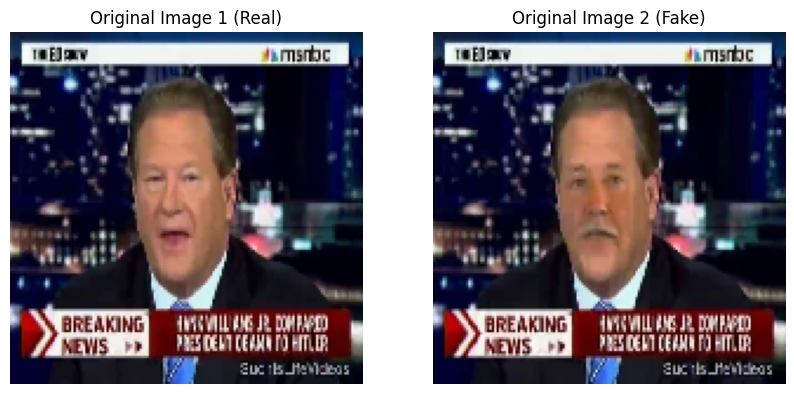

Displaying images in Dataset Dev:


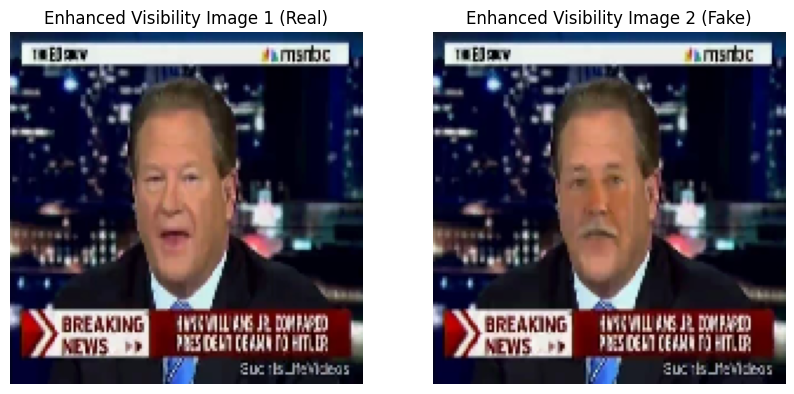

In [ ]:
# Plot images in Dataset D
print("Displaying images in Dataset D:")
plot_images(D, "Original")

# Plot images in Dataset Dev
print("Displaying images in Dataset Dev:")
plot_images(Dev, "Enhanced Visibility")

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess the image (resize to 3x3 for simplicity)
def preprocess_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize the values
    return img_array

# Load real and fake images
x1 = preprocess_image('frames_dataset\\009_frame_12.jpg')
x2 = preprocess_image('frames_dataset\\009_027_frame_12.jpg')

# Output the normalized datasets
print("Normalized x1 (real image):")
print(x1)

print("\nNormalized x2 (fake image):")
print(x2)

# Labels (1-hot encoding): [1, 0] for real, [0, 1] for fake
y1 = np.array([1, 0], dtype=np.float32)
y2 = np.array([0, 1], dtype=np.float32)

# Dataset
D = [(x1, y1), (x2, y2)]

# Initial Visibility Matrix v (3x3)
v = np.ones_like(x1)

# Define a simple model for demonstration (fθ)
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # Input shape is now (3, 3, 3) for RGB images
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# Initialize the model
model = build_model()

# Function to train the model on dataset D
def train_model(D, model, epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in D:
            x = np.expand_dims(x, axis=0)  # Add batch dimension
            y = np.expand_dims(y, axis=0)  # Add batch dimension
            
            # Train on batch
            loss = model.train_on_batch(x, y)
            total_loss += loss
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(D):.4f}')

# Function to update the visibility matrix v
def update_visibility_matrix(v, D, model):
    v_new = np.copy(v)  # Copy the current visibility matrix
    for x, y in D:
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        y_pred = model.predict(x, verbose=0)[0]  # Predict on x

        true_class = np.argmax(y)
        p = y_pred[true_class]

        # Update v based on loss for the true class
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                # Max(0, 1 - predicted_score * true_label)
                loss_v = max(0, 1 - p * y[true_class])
                v_new[i, j] -= 0.01 * loss_v  # Adjust v using a small learning rate (0.01)

    return np.clip(v_new, 0.5, 1.5)  # Ensure v stays in a reasonable range

# Function to create a new dataset Dev with enhanced visibility
def create_dev(D, v):
    Dev = []
    for x, y in D:
        v_x = v * x  # Element-wise multiplication
        Dev.append((v_x, y))
    return Dev



# Initial Training on Dataset D
print("Initial Training on Dataset D:")
train_model(D, model, epochs=5)

# Update the visibility matrix after the first iteration
print("\nUpdating visibility matrix after iteration 1:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

# Create new dataset Dev with enhanced visibility
Dev = create_dev(D, v)

# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev:")
train_model(Dev, model, epochs=5)

# Update the visibility matrix again (second iteration)
print("\nUpdating visibility matrix after iteration 2:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

# Create new dataset Dev after second iteration
Dev = create_dev(D, v)

# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev after second iteration:")
train_model(Dev, model, epochs=5)
# Update the visibility matrix again (second iteration)
print("\nUpdating visibility matrix after iteration 3:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

# Create new dataset Dev after second iteration
Dev = create_dev(D, v)

# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev after 3 iteration:")
train_model(Dev, model, epochs=5)

print("The Dataset D: ")
print(D)
print("The Dataset Dev: ")
print(Dev)


Normalized x1 (real image):
[[[0.06666667 0.12156863 0.15686275]
  [0.0627451  0.11764706 0.16078432]
  [0.06666667 0.10980392 0.18039216]
  ...
  [0.00392157 0.12941177 0.21960784]
  [0.01960784 0.12156863 0.1882353 ]
  [0.03529412 0.11764706 0.18431373]]

 [[0.09803922 0.14509805 0.2       ]
  [0.07450981 0.11764706 0.1882353 ]
  [0.07450981 0.11764706 0.20392157]
  ...
  [0.01176471 0.13333334 0.24313726]
  [0.03137255 0.1254902  0.21960784]
  [0.03921569 0.1254902  0.21568628]]

 [[0.12156863 0.18431373 0.24705882]
  [0.07843138 0.13725491 0.21960784]
  [0.07843138 0.13333334 0.23529412]
  ...
  [0.01176471 0.14901961 0.27450982]
  [0.03529412 0.14117648 0.24705882]
  [0.04313726 0.14509805 0.2509804 ]]

 ...

 [[0.         0.01568628 0.12941177]
  [0.00784314 0.         0.19215687]
  [0.00784314 0.         0.19215687]
  ...
  [0.         0.         0.03921569]
  [0.         0.         0.03921569]
  [0.         0.         0.03921569]]

 [[0.         0.01568628 0.12941177]
  [0.0078

c:\Users\kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Initial Training on Dataset D:
Epoch [1/5], Loss: 9.6425
Epoch [2/5], Loss: 11.9273
Epoch [3/5], Loss: 10.9188
Epoch [4/5], Loss: 10.8894
Epoch [5/5], Loss: 9.6700

Updating visibility matrix after iteration 1:
Updated Visibility Matrix v:
[[[0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  ...
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]]

 [[0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  ...
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]]

 [[0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  ...
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.99002063]]

 ...

 [[0.99002063 0.99002063 0.99002063]
  [0.99002063 0.99002063 0.

Displaying images in Dataset D:


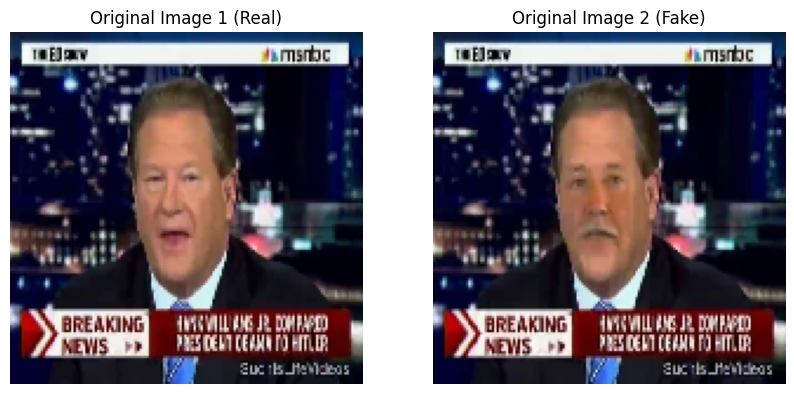

Displaying images in Dataset Dev:


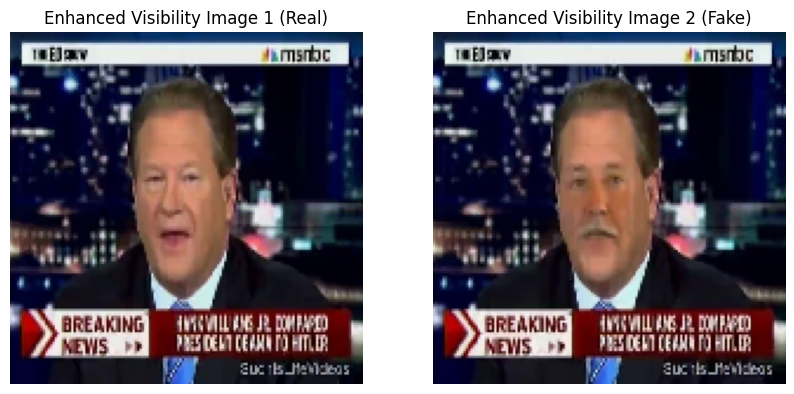

In [3]:
# Plot images in Dataset D
print("Displaying images in Dataset D:")
plot_images(D, "Original")

# Plot images in Dataset Dev
print("Displaying images in Dataset Dev:")
plot_images(Dev, "Enhanced Visibility")

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess the image (resize to 3x3 for simplicity)
def preprocess_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize the values
    return img_array

# Load real and fake images
x1 = preprocess_image('frames_dataset\\009_frame_12.jpg')
x2 = preprocess_image('frames_dataset\\009_027_frame_12.jpg')

# Output the normalized datasets
print("Normalized x1 (real image):")
print(x1)

print("\nNormalized x2 (fake image):")
print(x2)

# Labels (1-hot encoding): [1, 0] for real, [0, 1] for fake
y1 = np.array([1, 0], dtype=np.float32)
y2 = np.array([0, 1], dtype=np.float32)

# Dataset
D = [(x1, y1), (x2, y2)]

# Initial Visibility Matrix v (3x3)
v = np.ones_like(x1)

# Define a simple model for demonstration (fθ)
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # Input shape is now (3, 3, 3) for RGB images
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# Initialize the model
model = build_model()

# Function to train the model on dataset D
def train_model(D, model, epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in D:
            x = np.expand_dims(x, axis=0)  # Add batch dimension
            y = np.expand_dims(y, axis=0)  # Add batch dimension
            
            # Train on batch
            loss = model.train_on_batch(x, y)
            total_loss += loss
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(D):.4f}')

# Function to update the visibility matrix v
def update_visibility_matrix(v, D, model):
    v_new = np.copy(v)  # Copy the current visibility matrix
    for x, y in D:
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        y_pred = model.predict(x, verbose=0)[0]  # Predict on x

        true_class = np.argmax(y)
        p = y_pred[true_class]

        # Update v based on loss for the true class
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                # Max(0, 1 - predicted_score * true_label)
                loss_v = max(0, 1 - p * y[true_class])
                v_new[i, j] -= 0.01 * loss_v  # Adjust v using a small learning rate (0.01)

    return np.clip(v_new, 0.5, 1.5)  # Ensure v stays in a reasonable range

# Function to create a new dataset Dev with enhanced visibility
def create_dev(D, v):
    Dev = []
    for x, y in D:
        v_x = v * x  # Element-wise multiplication
        Dev.append((v_x, y))
    return Dev



# Initial Training on Dataset D
print("Initial Training on Dataset D:")
train_model(D, model, epochs=5)



for i in range(5):
    # Update the visibility matrix again (second iteration)
    print(f"\nUpdating visibility matrix after iteration {i+1}:")
    v = update_visibility_matrix(v, D, model)
    print(f"Updated Visibility Matrix v:\n{v}")

    # Create new dataset Dev after second iteration
    Dev = create_dev(D, v)

    # Retrain the model on the new dataset Dev
    print(f"\nRetraining on Dataset Dev after {i+1} iteration:")
    train_model(Dev, model, epochs=5)


print("The Dataset D: ")
print(D)
print("The Dataset Dev: ")
print(Dev)


Normalized x1 (real image):
[[[0.06666667 0.12156863 0.15686275]
  [0.0627451  0.11764706 0.16078432]
  [0.06666667 0.10980392 0.18039216]
  ...
  [0.00392157 0.12941177 0.21960784]
  [0.01960784 0.12156863 0.1882353 ]
  [0.03529412 0.11764706 0.18431373]]

 [[0.09803922 0.14509805 0.2       ]
  [0.07450981 0.11764706 0.1882353 ]
  [0.07450981 0.11764706 0.20392157]
  ...
  [0.01176471 0.13333334 0.24313726]
  [0.03137255 0.1254902  0.21960784]
  [0.03921569 0.1254902  0.21568628]]

 [[0.12156863 0.18431373 0.24705882]
  [0.07843138 0.13725491 0.21960784]
  [0.07843138 0.13333334 0.23529412]
  ...
  [0.01176471 0.14901961 0.27450982]
  [0.03529412 0.14117648 0.24705882]
  [0.04313726 0.14509805 0.2509804 ]]

 ...

 [[0.         0.01568628 0.12941177]
  [0.00784314 0.         0.19215687]
  [0.00784314 0.         0.19215687]
  ...
  [0.         0.         0.03921569]
  [0.         0.         0.03921569]
  [0.         0.         0.03921569]]

 [[0.         0.01568628 0.12941177]
  [0.0078

c:\Users\kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch [1/5], Loss: 9.8214
Epoch [2/5], Loss: 13.3030
Epoch [3/5], Loss: 10.4518
Epoch [4/5], Loss: 10.8261
Epoch [5/5], Loss: 10.7692

Updating visibility matrix after iteration 1:
Updated Visibility Matrix v:
[[[0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  ...
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]]

 [[0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  ...
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]]

 [[0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  ...
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]]

 ...

 [[0.99034464 0.99034464 0.99034464]
  [0.99034464 0.99034464 0.99034464]
  [0.99034464 0.9903

Displaying images in Dataset D:


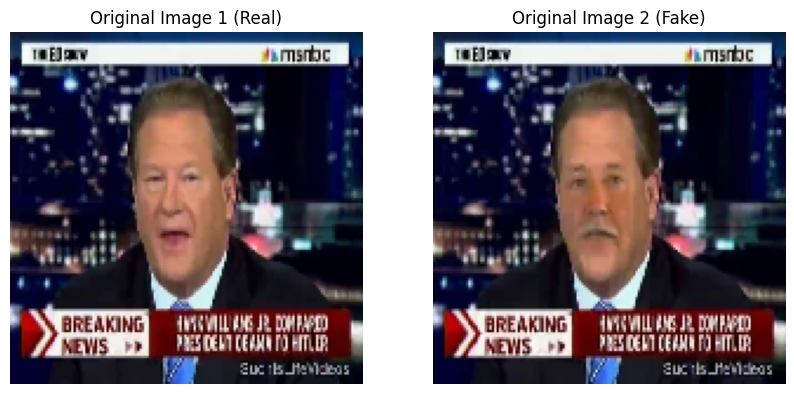

Displaying images in Dataset Dev:


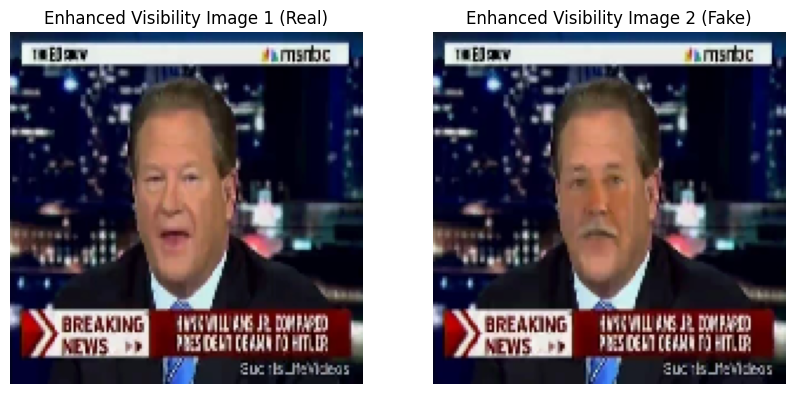

In [5]:
# Plot images in Dataset D
print("Displaying images in Dataset D:")
plot_images(D, "Original")

# Plot images in Dataset Dev
print("Displaying images in Dataset Dev:")
plot_images(Dev, "Enhanced Visibility")